<a href="https://colab.research.google.com/github/crdsteixeira/OR_project/blob/main/Scheduling_Aircraft_Landings_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the library

In [1]:
# !pip install docplex
# !pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 KB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.24.232-py3-none-any.whl size=682306 sha256=3ee9eebea53ecf32245b652bcdf1ab7642355b881fbb44656c4ddeb5cb07c7be
  Stored in directory: /root/.cache/pip/wheels/cd/84/5d/b9c307d9cf361c49d41ddea36761e226bba3afdfd038673dcd
Successfully built docplex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 19.8 MB/s eta 0:00:00


In [4]:
from docplex.cp.model import *
import numpy as np

# Info

The format of these data files is:
number of planes (p), freeze time
for each plane i (i=1,...,p):
   - appearance time, 
   - earliest landing time, 
   - target landing time,
   - latest landing time, 
   - penalty cost per unit of time for landing before target, 
   - penalty cost per unit of time for landing after target

for each plane j (j=1,...p): separation time required after 
                                i lands before j can land


### Sigle runway definitions and variables

![image.png](https://github.com/crdsteixeira/OR_project/blob/main/Images/single_run.png?raw=1)


### Multirunway defintions and variables 

![image.png](https://github.com/crdsteixeira/OR_project/blob/main/Images/multi_run.png?raw=1)

## Get data

In [284]:
def read_datafiles(file):
    with open(file, 'r') as data:
        data_lines = data.readlines()
        number_planes = int(data_lines[0].split()[0])
        freeze_time =  int(data_lines[0].split()[1])
        mixed_data = [line.split() for line in data_lines[1:] if not line.isspace()]
        mixed_data = [[(float(j)) for j in i] for i in mixed_data]
        
        flight_details = np.empty([0,6],dtype=float)
        separation_time = np.empty([0,number_planes],dtype=float)
        
        flag = 0
       
        for element in mixed_data:
            if flag == 0: # flight details
                flight_details = np.vstack([flight_details, np.array(element)])
                flag = 1
                element_final = []
            else:  # separation_times
                element_final.extend(element)
                if len(element_final) == number_planes:
                    separation_time = np.vstack([separation_time, np.array(element_final)])
                    flag = 0
                
#         print(f" number planes: {number_planes}")
#         print(f" freeze time: {freeze_time}")
#         print(f" mixed data: {mixed_data}")
#         print(f" flight details: {flight_details}")
#         print(f" separation time: {separation_time}")
    
    return number_planes, freeze_time, flight_details, separation_time


In [7]:
read_datafiles("./Data/airland1.txt")

(10, 10, array([[ 54., 129., 155., 559.,  10.,  10.],
        [120., 195., 258., 744.,  10.,  10.],
        [ 14.,  89.,  98., 510.,  30.,  30.],
        [ 21.,  96., 106., 521.,  30.,  30.],
        [ 35., 110., 123., 555.,  30.,  30.],
        [ 45., 120., 135., 576.,  30.,  30.],
        [ 49., 124., 138., 577.,  30.,  30.],
        [ 51., 126., 140., 573.,  30.,  30.],
        [ 60., 135., 150., 591.,  30.,  30.],
        [ 85., 160., 180., 657.,  30.,  30.]]), array([[9.9999e+04, 3.0000e+00, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [3.0000e+00, 9.9999e+04, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [1.5000e+01, 1.5000e+01, 9.9999e+04, 8.0000e+00, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00],
        [1.5000e+01, 1.5000e+01, 8.0000e+00, 9.9999e+04, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 

# The MIP model

In [287]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display
import matplotlib.pyplot as plt

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.All)
        plt.ion()
        self.fig = plt.figure(figsize=(10,4))
#         self.ax = self.fig.add_subplot(1,1,1)
    
    def notify_start(self):
        super(MipGapPlotter, self).notify_start()
        self.times =[]
        self.gaps = []
#         self.lines, = self.ax.plot([],[], 'o')
        plt.xlabel('time (ms)')
        plt.ylabel('gap (%)')
        
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        time = pdata.time
        self.times.append(1000* time)
        self.gaps.append(100*gap)
#         display.clear_output(wait=True)
        print(f"gap:. {gap}")
        plt.plot(self.times, self.gaps)
#         display.display(plt.gcf())
        

In [288]:
def MIP_model(file_name,R):
    from docplex.mp.model import Model
    mdl = Model("Scheduling Aircraft Landing - Multi Runway Static Case")
    
    P, freeze_time, flight_details, separation_time = read_datafiles(file_name)
    
    # The first column relates to the actual appearence time of the plane so will not be taken into account for our decision variables

    E = flight_details[:,1]  #earliest landing time,
    T = flight_details[:,2]  #target landing time,
    L = flight_details[:,3]  #latest landing time,
    g = flight_details[:,4]  #penalty cost per unit of time for landing before target,
    h = flight_details[:,5]  #penalty cost per unit of time for landing after target
    range_LT = max(flight_details[:,3]) - min(flight_details[:,1]) #landing range time

    # here we consider separation time between planes that land in different runways, fundamentally their value is the same as the separation time matrix but in constraints it should be multiplied by the binary variable that says if the planes land in the same runway or not
    s = np.zeros([P,P],dtype=float)

    ij = [(i,j) for i in np.arange(P) for j in np.arange(P)] # indexes for plane i and j landing in the same runway
    ir = [(i,r) for i in np.arange(P) for r in np.arange(R)] # indexes for plane i landing in runway r
    
    # Creating the time spaces
    W = []
    V = []
    U = []
    for i in range(P):
        for j in range(P):
            if i != j:
                if (L[i] < E[j]) and ((L[i] + separation_time[i, j]) <= E[j]):
                    W.append((i,j))
                elif (L[j] < E[j]) and ((L[i] + separation_time[i, j]) > E[j]): # windows intersept but we know that i lands before j
                    V.append((i,j))
                elif ((E[j] <= E[i]) and (E[i] <= L[j])) or ((E[j] <= L[i]) and (L[i] <= L[j])) or ((E[i] <= E[j]) and (E[j] <= L[i])) or ((E[i] <= L[j]) and (L[j] <= L[i])):
                    U.append((i,j)) # we don't know the order in which one lands
            else: 
                continue

    # Defining decision variables
    alpha   = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="alpha") # how soon a plane lands before target time
    beta    = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="beta") # how soon a plane lands after target time
    x       = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="x") # landing time for a plane
    sigma   = mdl.binary_var_dict(ij,lb=0,ub=1, name="sigma") # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    y       = mdl.binary_var_dict(ir,lb=0,ub=1, name="y") # 1 if plane i lands on runway  r , 0 otherwise
    z       = mdl.binary_var_dict(ij,lb=0,ub=1, name="z") # 1 if planes i and  j land on the same runway, 0 otherwise

    # Adding constraints    
    mdl.add_constraints(x[i]>=E[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be later than the earliest landing time
    mdl.add_constraints(x[i]<=L[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be earlier than the before latest landing time
    mdl.add_constraints((sigma[i,j]+sigma[j,i])==1 for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 2 - Plain i must land before plain j or plain j before plain i
    mdl.add_constraints(alpha[i]>=(T[i]-x[i]) for i in np.arange(P)) # Const 14 - How soon plane i lands before T[i] must be larger than T[i] - x[i]
    mdl.add_constraints(alpha[i]<=(T[i]-E[i]) for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be smaller than T[i] - E[i]
    mdl.add_constraints(alpha[i]>= 0 for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be at least zero
    mdl.add_constraints(beta[i]>=(x[i]-T[i]) for i in np.arange(P))  # Const 16 - How soon plane i lands after T[i] must be larger than x[i] - T[i]
    mdl.add_constraints(beta[i]<=(L[i]-T[i]) for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be smaller than L[i] - T[i]
    mdl.add_constraints(beta[i]>= 0 for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be at least zero
    mdl.add_constraints(x[i]==(T[i]-alpha[i]+beta[i]) for i in np.arange(P))  # Const 18 - Landing time is equal to target time minus arriving early or plus arriving late
   
    mdl.add_constraints(mdl.sum(y[i,r] for r in np.arange(R))==1 for i in np.arange(P))     # Const 28 - Plane i can only land in 1 runaway
    mdl.add_constraints(z[i,j]==z[j,i] for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j, plane j lands in the same runaway as plane i
    mdl.add_constraints(z[i,j]>=(y[i,r]+y[j,r]-1) for r in np.arange(R) for i in np.arange(P) for j in np.arange(P) if j>i) # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1. If z[i,j]=0 then the planes i and j cannot land on the same runaway 
    
    # Const 6 - If plane i lands before j we know that they belong in subspace W or V 
    mdl.add_constraints(sigma[i,j] == 1 for i in np.arange(P) for j in np.arange(P) if ((i,j) in V) or ((i,j) in W))
          
    # Const 12 - Separation time between plane i and plane j must be respected
    #mdl.add_constraints(x[j] >= (x[i] + (separation_time[i,j]*sigma[i,j]) - ((L[i] - E[j])*sigma[j,i])) for i in np.arange(P) 
    #                    for j in np.arange(P) if (i,j) in U and i != j)  

    # Const 31 - Landing times should respect separation times considering if they land in the same runway or not in subspace V
    mdl.add_constraints(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j])) for i in np.arange(P) 
                        for j in np.arange(P) if (i,j) in V)

    # Const 33 - Landing times should respect separation times considering if they land in the same runway or not in subspace U
    mdl.add_constraints(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + 
                                 s[i,j]*(1-z[i,j]) - (L[i] + max(separation_time[i,j], s[i,j]) - E[j])*sigma[j,i]) 
                        for i in np.arange(P) for j in np.arange(P) if (i,j) in U)


    cost_function = mdl.sum(beta[i] * h[i] + alpha[i] * g[i] for i in np.arange(P))

    mdl.minimize(cost_function)
    
    mdl.print_information()
    mdl.add_progress_listener(MipGapPlotter())

    msol = mdl.solve(clean_before_solve = True)
    assert msol is not None, "model can't solve"
    msol.export(f"{file_name}_{R}runway_solution.json")
    plt.savefig(f"{file_name}_{R}runway_gap-runtime.png")
    with open(f"{file_name}_{R}_runway_solution_time.txt", 'w') as f:
        print(mdl.solve_details, file = f)
        

    return mdl

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 126000
   - binary=125250, integer=0, continuous=750
 - number of constraints: 130631
   - linear=130631
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999977
gap:. 0.9999999999999977
gap:. 0.9999999999999959
gap:. 0.9999999999999959
gap:. 0.7355853975047861
gap:. 0.6886235796385278
gap:. 0.6886235796385278
gap:. 0.6533018341120161
gap:. 0.6533018341120161
gap:. 0.644205527918441
gap:. 0.644205527918441
gap:. 0.6399029771886322
gap:. 0.6399029771886322
gap:. 0.6369023483028381
gap:. 0.6215566576952758
gap:. 0.6215566576952758
gap:. 0.6198289099098091
gap:. 0.6198289099098091
gap:. 0.6190131151864106
gap:. 0.6164856551879543
gap:. 0.6162088749923714
gap:. 0.6155685488003714
gap:. 0.6155685488003714
gap:. 0.6142393787754348
gap:. 0.6142393787754348
gap:. 0.6139306677460767
gap:. 0.6119969809356779
gap:. 0.6119969809356779
gap:. 0.6113511945272763
gap:. 0.610879

gap:. 0.43921144156408254
gap:. 0.4391560763789158
gap:. 0.43910338181929454
gap:. 0.43909458631770987
gap:. 0.43902404291146313
gap:. 0.4389626584444693
gap:. 0.4389099984031458
gap:. 0.4388681832954458
gap:. 0.4388140635355876
gap:. 0.4387936565579457
gap:. 0.4387335616942884
gap:. 0.4386843019110396
gap:. 0.4386363931920712
gap:. 0.43858275240897876
gap:. 0.4385313744757536
gap:. 0.4385063899456853
gap:. 0.4384584137737494
gap:. 0.4384080974771092
gap:. 0.4383679557849708
gap:. 0.43809773994886847
gap:. 0.437589901271021
gap:. 0.43753936990205505
gap:. 0.4374994093212273
gap:. 0.4374407414474904
gap:. 0.4374045627108116
gap:. 0.4373598556385602
gap:. 0.4373151018459345
gap:. 0.43726517804563375
gap:. 0.43722050997153344
gap:. 0.4371739793807809
gap:. 0.43712033234296593
gap:. 0.4370713424193756
gap:. 0.4370172358789554
gap:. 0.4369828449979461
gap:. 0.4369371266260248
gap:. 0.43688573555073795
gap:. 0.43683008924150196
gap:. 0.4368044692964645
gap:. 0.436742965148655
gap:. 0.4366911

gap:. 0.4275158298234514
gap:. 0.42748858511059623
gap:. 0.4274531353727945
gap:. 0.4274295944695028
gap:. 0.42740331159376155
gap:. 0.4273791535562933
gap:. 0.4273484889783779
gap:. 0.42732326745393384
gap:. 0.4273000131199486
gap:. 0.4272749922641134
gap:. 0.42725635586391203
gap:. 0.4272363661702626
gap:. 0.4272104968888695
gap:. 0.42717999024296216
gap:. 0.42715567287573114
gap:. 0.4271234845933016
gap:. 0.42709728300590627
gap:. 0.42706905116242794
gap:. 0.42597430621106747
gap:. 0.4259440108203642
gap:. 0.42592521935056704
gap:. 0.4258958822715513
gap:. 0.4258539059859217
gap:. 0.4258195749603324
gap:. 0.42579250336390295
gap:. 0.42576767166620383
gap:. 0.4257362652667598
gap:. 0.42570432837638594
gap:. 0.42568033463132887
gap:. 0.42565369304609835
gap:. 0.4256270836139615
gap:. 0.42560807264107997
gap:. 0.42558827872038635
gap:. 0.42555839517806104
gap:. 0.42552794433028707
gap:. 0.42550171231501605
gap:. 0.4254772261405337
gap:. 0.425457091412628
gap:. 0.4254267031782288
gap:. 

gap:. 0.41713405320105384
gap:. 0.41709955243023233
gap:. 0.41705825894561005
gap:. 0.417030175403124
gap:. 0.41700251806482697
gap:. 0.4169662623099026
gap:. 0.41693048526099696
gap:. 0.41689415353678055
gap:. 0.4168652997453215
gap:. 0.41683712430595504
gap:. 0.4168049300184375
gap:. 0.4167654874684218
gap:. 0.4167327725928311
gap:. 0.4166943053651352
gap:. 0.41666543022565067
gap:. 0.41663012158790824
gap:. 0.4165930826117155
gap:. 0.4165551544296461
gap:. 0.41652259907132627
gap:. 0.4164924674958786
gap:. 0.41646207941063157
gap:. 0.41643224563126297
gap:. 0.4163998561135281
gap:. 0.41636440027780497
gap:. 0.41633145775324915
gap:. 0.4163054428657665
gap:. 0.416271334450918
gap:. 0.4162380370761112
gap:. 0.416204785567427
gap:. 0.4161665810777724
gap:. 0.41614186443909257
gap:. 0.41611179873701715
gap:. 0.4160824737687169
gap:. 0.416046387458603
gap:. 0.4160107001263358
gap:. 0.41598168031859883
gap:. 0.4159741023854041
gap:. 0.4159398374073499
gap:. 0.4159031224723182
gap:. 0.4158

gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.4106

gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.41063736189329036
gap:. 0.4106

gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173
gap:. 0.4101841663694173


gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.40943589283370124
gap:. 0.4094

gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017


gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017


gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4021232424983017
gap:. 0.4019277441077952
gap:. 0.4018949750585718
gap:. 0.4017932733798824
gap:. 0.4017932733798824
gap:. 0.40162347656734926
gap:. 0.4013550120370585
gap:. 0.40096879194606305
gap:. 0.40085430542802813
gap:. 0.4004438401018859
gap:. 0.4002763776183326
gap:. 0.3989572371525813
gap:. 0.3979274528007141
gap:. 0.3978404107019433
gap:. 0.3978201836376021
gap:. 0.3978095357645268
gap:. 0.3978095357645268
gap:. 0.39774743671537083
gap:. 0.3977359048983265
gap:. 0.3977307191011774
gap:. 0.3977297641900078
gap:. 0.3977297641900078
gap:. 0.3977297641900078
gap:. 0.3977297641900078
gap:. 0.3977297641900078
gap:. 0.3977297641900

gap:. 0.3974458889097823
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153


gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153
gap:. 0.3967031645430153


gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806
gap:. 0.3947586990643806


KeyboardInterrupt: None

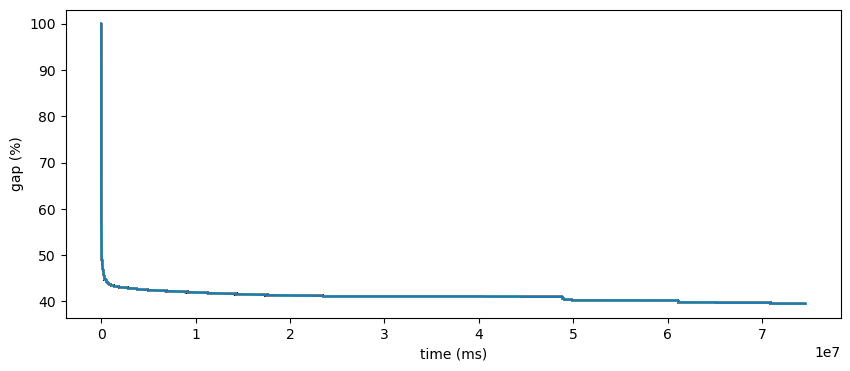

In [289]:
# file_name = f"./Data/airland{i}.txt"
R = [1, 2] 

for i in range(12, 13):
    for j in R:
        mdl_ = MIP_model(f"./Data/airland{i}.txt", j)
        mdl_.report()
        mdl_.print_solution()
        print(mdl_.solve_details)

## The CP model

In [293]:
from docplex.cp.model import CpoModel

def CP_model(file_name, R):
    # Create a new model
    mdl = CpoModel()

    P, freeze_time, flight_details, separation_time = read_datafiles(file_name)

    # The first column relates to the actual appearence time of the plane so will not be taken into account for our decision variables
    E = flight_details[:,1]  # earliest landing time
    T = flight_details[:,2]  # target landing time
    L = flight_details[:,3]  # latest landing time
    g = flight_details[:,4]  # penalty cost per unit of time for landing before target
    h = flight_details[:,5]  # penalty cost per unit of time for landing after target
    range_LT = max(flight_details[:,3]) - min(flight_details[:,1])  # landing range time

    s = np.zeros([P,P],dtype=float)

    ij = [(i,j) for i in np.arange(P) for j in np.arange(P)] # indexes for plane i and j landing in the same runway
    ir = [(i,r) for i in np.arange(P) for r in np.arange(R)] # indexes for plane i landing in runway r
    
    # Creating the time spaces
    W = []
    V = []
    U = []
    for i in range(P):
        for j in range(P):
            if i != j:
                if (L[i] < E[j]) and ((L[i] + separation_time[i, j]) <= E[j]):
                    W.append((i,j))
                elif (L[j] < E[j]) and ((L[i] + separation_time[i, j]) > E[j]): # windows intersept but we know that i lands before j
                    V.append((i,j))
                elif ((E[j] <= E[i]) and (E[i] <= L[j])) or ((E[j] <= L[i]) and (L[i] <= L[j])) or ((E[i] <= E[j]) and (E[j] <= L[i])) or ((E[i] <= L[j]) and (L[j] <= L[i])):
                    U.append((i,j)) # we don't know the order in which one lands
            else: 
                continue

    # Defining decision variables

    alpha = mdl.integer_var_list(P, 0, int(max(L)), name="alpha")  # how soon a plane lands before target time
    beta  = mdl.integer_var_list(P, 0, int(max(L)), name="beta")  # how soon a plane lands after target time
    x = [mdl.integer_var(int(E[i]), int(L[i]), name="x_{}".format(i)) for i in np.arange(P)]  # landing time for a plane

    #sigma = mdl.binary_var_list(P, name="sigma")  # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    sigma = {}
    for i, j in ij:
        sigma[i, j] = mdl.binary_var(name="sigma_{}_{}".format(i, j)) # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    y = {}
    for i, r in ir:
        y[i, r] = mdl.binary_var(name="y_{}_{}".format(i, r))# 1 if plane i lands on runway  r , 0 otherwise
    
    z = {}
    for i, j in ij:
        z[i, j] = mdl.binary_var(name="z_{}_{}".format(i, j))# 1 if plane i lands on runway  r , 0 otherwise

    # Defining constraints
    mdl.add(x[i]>=E[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be later than the earliest landing time
    mdl.add(x[i]<=L[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be earlier than the before latest landing time
    mdl.add((sigma[i,j]+sigma[j,i])==1 for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 2 - Plain i must land before plain j or plain j before plain i
    mdl.add(alpha[i]>=(T[i]-x[i]) for i in np.arange(P)) # Const 14 - How soon plane i lands before T[i] must be larger than T[i] - x[i]
    mdl.add(alpha[i]<=(T[i]-E[i]) for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be smaller than T[i] - E[i]
    mdl.add(alpha[i]>= 0 for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be at least zero
    mdl.add(beta[i]>=(x[i]-T[i]) for i in np.arange(P))  # Const 16 - How soon plane i lands after T[i] must be larger than x[i] - T[i]
    mdl.add(beta[i]<=(L[i]-T[i]) for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be smaller than L[i] - T[i]
    mdl.add(beta[i]>= 0 for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be at least zero
    mdl.add(x[i]==(T[i]-alpha[i]+beta[i]) for i in np.arange(P))  # Const 18 - Landing time is equal to target time minus arriving early or plus arriving late
   
    mdl.add(mdl.sum(y[i,r] for r in np.arange(R))==1 for i in np.arange(P))     # Const 28 - Plane i can only land in 1 runaway
    mdl.add(z[i,j]==z[j,i] for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j, plane j lands in the same runaway as plane i
    mdl.add(z[i,j]>=(y[i,r]+y[j,r]-1) for r in np.arange(R) for i in np.arange(P) for j in np.arange(P) if j>i) # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1. If z[i,j]=0 then the planes i and j cannot land on the same runaway 
    
    # Const 6 - If plane i lands before j we know that they belong in subspace W or V 
    mdl.add(sigma[i,j] == 1 for i in np.arange(P) for j in np.arange(P) if ((i,j) in V) or ((i,j) in W))
          
    # Const 12 - Separation time between plane i and plane j must be respected
    #mdl.add_constraints(x[j] >= (x[i] + (separation_time[i,j]*sigma[i,j]) - ((L[i] - E[j])*sigma[j,i])) for i in np.arange(P) 
    #                    for j in np.arange(P) if (i,j) in U and i != j)  

    # Const 31 - Landing times should respect separation times considering if they land in the same runway or not in subspace V
    mdl.add(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j])) for i in np.arange(P) 
                        for j in np.arange(P) if (i,j) in V)

    # Const 33 - Landing times should respect separation times considering if they land in the same runway or not in subspace U
    mdl.add(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + 
                                 s[i,j]*(1-z[i,j]) - (L[i] + max(separation_time[i,j], s[i,j]) - E[j])*sigma[j,i]) 
                        for i in np.arange(P) for j in np.arange(P) if (i,j) in U)
        
    # Objective function
    mdl.minimize(mdl.sum(g[i] * alpha[i] + h[i] * beta[i] for i in np.arange(P)))

    # Solve model
    msol = mdl.solve(LogVerbosity='Terse')
    
    # Print solution
    data={}
    CPLEXSolution = {}
    header = {}
    variables = []
    
    for i in range(P):
        for j in range(P):
            if i != j:
                sol = str("{}".format(msol.get_var_solution(sigma[i, j])))
                el = {}
                el["name"] = (sol.split("=")[0])
                el["value"] = (sol.split("=")[1])
                variables.append(el)
    for i in range(P):
        for j in range(P):
            if i != j:
                sol = str("{}".format(msol.get_var_solution(z[i, j])))
                el = {}
                el["name"] = (sol.split("=")[0])
                el["value"] = (sol.split("=")[1])
                variables.append(el)
            
    for i in range(P):
        sol = str("{}".format(msol.get_var_solution(x[i])))
        el = {}
        el["name"] = (sol.split("=")[0])
        el["value"] = (sol.split("=")[1])
        variables.append(el)
        
    for i in range(P):
        sol = str("{}".format(msol.get_var_solution(alpha[i])))
        el = {}
        el["name"] = (sol.split("=")[0])
        el["value"] = (sol.split("=")[1])
        variables.append(el)
        
    for i in range(P):
        sol = str("{}".format(msol.get_var_solution(beta[i])))
        el = {}
        el["name"] = (sol.split("=")[0])
        el["value"] = (sol.split("=")[1])
        variables.append(el)
        
    for i in range(len(variables)):
        variables[i]["index"] = str(i)
    
    header["objectiveValue"] = str(msol.get_objective_value())
    CPLEXSolution["header"] = header
    CPLEXSolution["variables"] = variables
    data["CPLEXSolution"] = CPLEXSolution
    
    data = json.dumps(data)
    
    with open(f"{file_name}_{R}_runway_solution_cp.json", 'w') as f:
        print(data, file = f)
        
    with open(f"{file_name}_{R}_runway_solution_time_cp.txt", 'w') as f:
        print("run_time={}".format(msol.get_solve_time()), file = f)
    

In [ ]:
R = [2] 

for i in range(4, 5):
    for j in R:
        mdl_ = CP_model(f"./Data/airland{i}.txt", j)

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 860 variables, 1340 constraints
 ! Presolve      : 380 extractables eliminated
 ! LogVerbosity         = Terse
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 1053.6 (before), 1053.6 (after)
 !  . Memory usage      : 1.1 MB (before), 1.1 MB (after)
 ! Using parallel search with 12 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        860                 -
 + New bound is 0
                      120        186    1   F     0 != y_0_1
 + New bound is 1
 *         56390      324  0.15s        3      (gap is 100.00%)
 *         56370     1104  0.20s        3      (gap is 100.00%)
 *         40030     3173  0.29s       11      (gap is 100.00%)
 *         22440     3258  0.29s        7      (gap is 100.00%)
 *

## The modified CP model

In [33]:
def read_datafiles_sorted(file):
    with open(file, 'r') as data:
        data_lines = data.readlines()
        number_planes = int(data_lines[0].split()[0])
        freeze_time =  int(data_lines[0].split()[1])
        mixed_data = [line.split() for line in data_lines[1:] if not line.isspace()]
        mixed_data = [[int(float(j)) for j in i] for i in mixed_data]
        
        flight_details = np.empty([0,6],dtype=int)
        separation_time = np.empty([0,number_planes],dtype=int)
        
        flag = 0
       
        for element in mixed_data:
            if flag == 0: # flight details
                flight_details = np.vstack([flight_details, np.array(element)])
                flag = 1
                element_final = []
            else:  # separation_times
                element_final.extend(element)
                if len(element_final) == number_planes:
                    separation_time = np.vstack([separation_time, np.array(element_final)])
                    flag = 0

    def sort_list(l1, l2):
        idx = np.argsort(-l1[:,2])
        res_1 = np.array(l1[idx[::-1]])
        res_2 = np.array(l2[idx[::-1]])
        for i in range(len(res_2)):
            res_2[i,:] = res_2[i,idx[::-1]]
        return res_1, res_2

    flight_details, separation_time = sort_list(flight_details, separation_time)

    return number_planes, freeze_time, flight_details, separation_time

In [34]:
def CP_model_modi(file_name, R):
    # Create a new model
    mdl = CpoModel()
    RES = 1
    #mdl.set_parameters(CpoParameters(Workers=1, SearchType="DepthFirst"))
    
    P, freeze_time, flight_details, separation_time = read_datafiles_sorted(file_name)

    # The first column relates to the actual appearence time of the plane so
    # will not be taken into account for our decision variables
    E = flight_details[:,1] # earliest landing time
    T = flight_details[:,2] # target landing time
    L = flight_details[:,3] # latest landing time
    g = flight_details[:,4] # penalty cost per unit of time for landing before target
    h = flight_details[:,5] # penalty cost per unit of time for landing after target
    separation_time = separation_time

    # Creating the time spaces
    W = []
    V = []
    U = []
    for i in range(P):
        for j in range(P):
            if j != i:
                if (L[i] <= E[j]) and ((L[i] + separation_time[i, j]) <= E[j]):
                    W.append((i,j))
                elif (L[i] <= E[j]) and ((L[i] + separation_time[i, j]) > E[j]): # windows intersept but we know that i lands before j
                    V.append((i,j))
                elif ((E[j] <= E[i]) and (E[i] <= L[j])) or ((E[j] <= L[i]) and (L[i] <= L[j])) or ((E[i] <= E[j]) and (E[j] <= L[i])) or ((E[i] <= L[j]) and (L[j] <= L[i])):
                    U.append((i,j)) # we don't know the order in which one lands
            else: 
                continue

    landing_times = mdl.integer_var_list(P, min(E), max(L), "landing_time")
    z = mdl.binary_var_list(P * P, name="z")
    sigma = mdl.binary_var_list(P * P, name="sigma")
    landings = mdl.binary_var_list(P * R, name="landings")
    is_early = mdl.binary_var_list(P, name="is_early")
    is_late = mdl.binary_var_list(P, name="is_late")

    mdl.add(mdl.sum(landings[i * R + r] for r in range(R)) == 1 for i in range(P))
    mdl.add(z[i * P + j] == z[j * P + i] for i in range(P) for j in range(P) if j > i)
    mdl.add(z[i * P + j] >= landings[i * R + r] + landings[j * R + r] - 1 for i in range(P) for r in range(R) for j in range(P) if j > i) 
    mdl.add(sigma[i * P + j] + sigma[j * P + i] == 1 for i in range(P) for j in np.arange(P) if i != j)
    mdl.add(sigma[i * P + j] == 1 for i in range(P) for j in range(P) if ((i, j) in V) or ((i, j) in W))
    mdl.add(landing_times[j] >= landing_times[i] + separation_time[i, j]*z[i * P + j] for i in range(P) for j in range(P) if (i, j) in V)
    mdl.add(landing_times[j] >= landing_times[i] + separation_time[i, j]*z[i * P + j] - 
            (L[i] + separation_time[i, j] - E[j])*sigma[j * P + i] for i in range(P) for j in range(P) if (i,j) in U)
    mdl.add(landing_times[i] >= E[i] for i in range(P))
    mdl.add(landing_times[i] <= L[i] for i in range(P))
    mdl.add(mdl.if_then(landing_times[i] < T[i], is_early[i] == 1) for i in range(P))
    mdl.add(mdl.if_then(landing_times[i] >= T[i], is_early[i] == 0) for i in range(P))
    mdl.add(mdl.if_then(landing_times[i] > T[i], is_late[i] == 1) for i in range(P))
    mdl.add(mdl.if_then(landing_times[i] <= T[i], is_late[i] == 0) for i in range(P))
    
    mdl.add(mdl.minimize(mdl.sum((T[i] - landing_times[i])*g[i]*is_early[i] +
                                 (landing_times[i] - T[i])*h[i]*is_late[i] for i in range(P))))
    #mdl.add(mdl.minimize(mdl.sum(mdl.abs(landing_times[i] - T[i]) for i in range(P))))

    #landing_times = [mdl.integer_var(int(E[i]), int(L[i]), "landing_time_{}".format(i)) for i in range(P)]
    #z = {}
    #sigma = {}
    #for i in range(P):
    #    for j in range(P):
    #        if j != i:
    #            z[(i, j)] = mdl.binary_var(name="z_{}_{}".format(i, j))
    #            sigma[(i, j)] = mdl.binary_var(name="sigma_{}_{}".format(i, j))
    #landings = {}
    #for i in range(P):
    #    for r in range(R):
    #        landings[(i, r)] = mdl.binary_var(name="landings_{}_{}".format(i, r))
    
    # Landing Times
    #if R == 1:
    #    mdl.all_diff(landing_times)
    #for i in range(P):
    #    mdl.add(mdl.sum(landings[(i, r)] for r in range(R)) == 1)

    # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j,
    # plane j lands in the same runaway as plane i
    #mdl.add(z[(i, j)] == z[(j, i)] for i in range(P) for j in range(P) if j > i)
    
    # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1.
    # If z[i,j]=0 then the planes i and j cannot land on the same runaway
    #mdl.add(z[(i, j)] >= (landings[(i, r)] + landings[(j, r)] - 1) for r in range(R) for i in range(P) for j in range(P) if j > i) 
        
    # Const 2 - Plain i must land before plain j or plain j before plain i
    #mdl.add((sigma[(i, j)] + sigma[(j, i)]) == 1 for i in np.arange(P) for j in np.arange(P) if i != j)
    #mdl.add(sigma[(i, j)] == 1 for i in range(P) for j in range(P) if ((i,j) in V) or ((i,j) in W))
    #mdl.add(landing_times[j] >= landing_times[i] + separation_time[i, j]*z[i, j]
    #        for i in range(P) for j in range(P) if (i,j) in V)
    #mdl.add(landing_times[j] >= landing_times[i] + separation_time[i, j]*z[i, j] -
    #        (L[i] + separation_time[i, j] - E[j])*sigma[j, i]
    #        for i in range(P) for j in range(P) if (i,j) in U)

    #for i in range(P):
        #mdl.add(landing_times[i] >= min(E))
        #mdl.add(landing_times[i] <= max(L))
        # Const 1 - Landing time of plane i must be later than the earliest landing time
        #mdl.add(landing_times[i] >= E[i])
        # Const 1 - Landing time of plane i must be earlier than the before latest landing time
        #mdl.add(landing_times[i] <= L[i])
        #
        #
        #mdl.add(runway[i] <= R)
        #mdl.add(runway[i] >= 0)

    # Separation Times
    #for i in range(P-1):
    #    for j in range(i+1, P):
    #        if i != j:
    #            for r in range(R):
    #                mdl.add(mdl.abs(landing_times[j] - landing_times[i]) >=
    #                        separation_time[i, j]*(landings[(i, r)] == landings[(j, r)]))
    #                #mdl.add(mdl.if_then(mdl.abs(landing_times[j] - landing_times[i]) >= separation_time[i, j],
    #                #        landings[i, j, r] == 1))
    # Separation Times
    #for i in range(P):
    #    for j in range(P):
    #        if i != j:
    #            #mdl.add(mdl.if_then(runway[i] == runway[j],
    #            #        mdl.abs(landing_times[j] - landing_times[i]) >= separation_time[i, j]))

    #for i in range(P):
    #    mdl.add(mdl.if_then(landing_times[i] < T[i], is_early[i] == 1))
    #    mdl.add(mdl.if_then(landing_times[i] >= T[i], is_early[i] == 0))
    #    mdl.add(mdl.if_then(landing_times[i] > T[i], is_late[i] == 1))
    #    mdl.add(mdl.if_then(landing_times[i] <= T[i], is_late[i] == 0))

    # Minimize total cost
    #stp = mdl.create_empty_solution()
    #for i in range(P):
    #    stp[landing_times[i]] = int(T[i])
    #mdl.set_starting_point(stp)

    msol = mdl.solve(SearchType='Restart', DefaultInferenceLevel='Extended',
                     LogVerbosity='Quiet')

    cost = 0
    for i in range(P):
        val = msol.get_value(landing_times[i]) / RES
        cost += (T[i] / RES - val) * g[i] if (T[i] / RES >= val) else (val - T[i] / RES) * h[i]
        #print("Aircraft {}: landing at {} at {}".format(i, val, msol.get_var_solution(landings[(i, i, 0)])))
        print("Aircraft {}: landing at {}".format(i, val))
    print(msol.get_objective_value())
    print(msol.get_solve_time())
    print(cost)




     # Print solution
    data={}
    CPLEXSolution = {}
    header = {}
    variables = []
    
    for i in range(P):
        for j in range(P):
            if i !=j:
                sol = str("{}".format(msol.get_var_solution(sigma[i * P + j])))
#                 print(sigma[i * P + j])
#                 print(msol.get_var_solution(sigma[i * P + j]))
#                 print(sol)
                el = {}
                el["name"] = (sol.split("=")[0])
                el["value"] = (sol.split("=")[1])
                variables.append(el)
    for i in range(P):
        for j in range(P):
            if i!= j :
                sol = str("{}".format(msol.get_var_solution(z[i * P + j])))
                el = {}
                el["name"] = (sol.split("=")[0])
                el["value"] = (sol.split("=")[1])
                variables.append(el)
            
    for i in range(P):
        sol = str("{}".format(msol.get_var_solution(landing_times[i])))
        el = {}
        el["name"] = (sol.split("=")[0])
        el["value"] = (sol.split("=")[1])
        variables.append(el)
        
    for i in range(P):
        sol = str("{}".format(msol.get_var_solution(is_early[i])))
        el = {}
        el["name"] = (sol.split("=")[0])
        el["value"] = (sol.split("=")[1])
        variables.append(el)
        
    for i in range(P):
        sol = str("{}".format(msol.get_var_solution(is_late[i])))
        el = {}
        el["name"] = (sol.split("=")[0])
        el["value"] = (sol.split("=")[1])
        variables.append(el)
    
    for i in range(P):
        for j in range(R):
            sol = str("{}".format(msol.get_var_solution(landings[i * R + j])))
            el = {}
            el["name"] = (sol.split("=")[0])
            el["value"] = (sol.split("=")[1])
            variables.append(el)  
    
    
    for i in range(len(variables)):
        variables[i]["index"] = str(i)
    
    header["objectiveValue"] = str(msol.get_objective_value())
    CPLEXSolution["header"] = header
    CPLEXSolution["variables"] = variables
    data["CPLEXSolution"] = CPLEXSolution
    
    data = json.dumps(data)
    
    with open(f"{file_name}_{R}_runway_solution_cp_modified.json", 'w') as f:
        print(data, file = f)
        
    with open(f"{file_name}_{R}_runway_solution_time_cp_modified.txt", 'w') as f:
        print("run_time={}".format(msol.get_solve_time()), file = f)
    

In [ ]:
# file_name = f"./Data/airland{i}.txt"
R = [1, 2] 

# Create a ConstraintOperator object for the "x <= y" constraint
#op = ConstraintOperator(name="pair_E_W", arity=2, inf=0, sup=1)
#op.register(x_leq_y_constraint)

for i in range(5, 9): #range(11, 14):
    for j in R:
        print("Problem {} runway {}".format(i, j))
        mdl_ = CP_model_modi(f"./Data/airland{i}.txt", j)
        #mdl_.report()
        #mdl_.print_solution()
        #print(mdl_.solve_details)

Problem 5 runway 1
